# Reducing Failure-Inducing Inputs

By construction, fuzzers create inputs that may be hard to read.  This causes issues during _debugging_, when a human has to analyze the exact cause of the failure.  In this chapter, we present techniques that _automatically reduce and simplify failure-inducing inputs to a minimum_ in order to ease debugging.

In [1]:
from bookutils import YouTubeVideo
YouTubeVideo('noJUPjSJVh0')

**Prerequisites**

* The simple "delta debugging" technique for reduction has no specific prerequisites.
* As reduction is typically used together with fuzzing, reading the [chapter on basic fuzzing](Fuzzer.ipynb) is a good idea.
* The later grammar-based techniques require knowledge on [derivation trees](GrammarFuzzer.ipynb) and [parsing](Parser.ipynb).

## Synopsis
<!-- Automatically generated. Do not edit. -->

To [use the code provided in this chapter](Importing.ipynb), write

```python
>>> from fuzzingbook.Reducer import <identifier>
```

and then make use of the following features.


A _reducer_ takes a failure-inducing input and reduces it to the minimum that still reproduces the failure.  This chapter provides `Reducer` classes that implement such reducers.

Here is a simple example: An arithmetic expression causes an error in the Python interpreter:

```python
>>> !python -c 'x = 1 + 2 * 3 / 0'
Traceback (most recent call last):
  File "<string>", line 1, in <module>
ZeroDivisionError: division by zero

```
Can we reduce this input to a minimum?  To use a `Reducer`, one first has to build a `Runner` whose outcome is `FAIL` if the precise error occurs.  We therefore build a `ZeroDivisionRunner` whose `run()` method will specifically return a `FAIL` outcome if a `ZeroDivisionError` occurs.

```python
>>> from Fuzzer import ProgramRunner
>>> import subprocess
>>> class ZeroDivisionRunner(ProgramRunner):
>>>     """Make outcome 'FAIL' if ZeroDivisionError occurs"""
>>> 
>>>     def run(self, inp: str = "") -> Tuple[subprocess.CompletedProcess, Outcome]:
>>>         process, outcome = super().run(inp)
>>>         if process.stderr.find('ZeroDivisionError') >= 0:
>>>             outcome = 'FAIL'
>>>         return process, outcome
```
If we feed this expression into a `ZeroDivisionRunner`, it will produce an outcome of `FAIL` as designed.

```python
>>> python_input = "x = 1 + 2 * 3 / 0"
>>> python_runner = ZeroDivisionRunner("python")
>>> process, outcome = python_runner.run(python_input)
>>> outcome
'FAIL'
```
Delta Debugging is a simple and robust reduction algorithm.  We can tie a `DeltaDebuggingReducer` to this runner, and have it determine the substring that causes the `python` program to fail:

```python
>>> dd = DeltaDebuggingReducer(python_runner)
>>> dd.reduce(python_input)
'3/0'
```
The input is reduced to the minimum: We get the essence of the division by zero.

![](PICS/Reducer-synopsis-1.svg)



## Why Reducing?

At this point, we have seen a number of test generation techniques that all in some form produce inputs in order to trigger failures.  If they are successful – that is, the program actually fails – we must find out why the failure occurred and how to fix it.

Here's an example of such a situation.  We have a class `MysteryRunner` with a `run()` method that – given its code – can occasionally fail.  But under which circumstances does this actually happen?  We have deliberately obscured the exact condition in order to make this non-obvious.

In [2]:
import bookutils

In [3]:
from bookutils import quiz

In [4]:
from typing import Tuple, List, Sequence, Any, Optional

In [5]:
from ExpectError import ExpectError

In [6]:
from Fuzzer import RandomFuzzer, Runner, Outcome

In [7]:
import re

In [8]:
class MysteryRunner(Runner):
    def run(self, inp: str) -> Tuple[str, Outcome]:
        x = inp.find(chr(0o17 + 0o31))
        y = inp.find(chr(0o27 + 0o22))
        if x >= 0 and y >= 0 and x < y:
            return (inp, Runner.FAIL)
        else:
            return (inp, Runner.PASS)

Let us fuzz the function until we find a failing input.

In [9]:
mystery = MysteryRunner()
random_fuzzer = RandomFuzzer()
while True:
    inp = random_fuzzer.fuzz()
    result, outcome = mystery.run(inp)
    if outcome == mystery.FAIL:
        break

In [10]:
failing_input = result
failing_input

' 7:,>((/$$-/->.;.=;(.%!:50#7*8=$&&=$9!%6(4=&69\':\'<3+0-3.24#7=!&60)2/+";+<7+1<2!4$>92+$1<(3%&5\'\'>#'

Something in this input causes `MysteryRunner` to fail.  But what is it?

## Manual Input Reduction

One important step in the debugging process is _reduction_ – that is, to identify those circumstances of a failure that are relevant for the failure to occur, and to _omit_ (if possible) those parts that are not.  As Kernighan and Pike \cite{Kernighan1999} put it:

> For every circumstance of the problem, check whether it is relevant for the problem to occur.  If it is not, remove it from the problem report or the test case in question.

Specifically for inputs, they suggest a _divide and conquer_ process:

> Proceed by binary search.  Throw away half the input and see if the output is still wrong; if not, go back to the previous state and discard the other half of the input.

This is something we can easily try out, using our last generated input:

In [11]:
failing_input

' 7:,>((/$$-/->.;.=;(.%!:50#7*8=$&&=$9!%6(4=&69\':\'<3+0-3.24#7=!&60)2/+";+<7+1<2!4$>92+$1<(3%&5\'\'>#'

For instance, we can see whether the error still occurs if we only feed in the first half:

In [12]:
half_length = len(failing_input) // 2   # // is integer division
first_half = failing_input[:half_length]
mystery.run(first_half)

(" 7:,>((/$$-/->.;.=;(.%!:50#7*8=$&&=$9!%6(4=&69':", 'PASS')

Nope – the first half alone does not suffice.  Maybe the second half?

In [13]:
second_half = failing_input[half_length:]
mystery.run(second_half)

('\'<3+0-3.24#7=!&60)2/+";+<7+1<2!4$>92+$1<(3%&5\'\'>#', 'PASS')

This did not go so well either.  We may still proceed by cutting away _smaller chunks_ – say, one character after another.  If our test is deterministic and easily repeated, it is clear that this process eventually will yield a reduced input.  But still, it is a rather inefficient process, especially for long inputs.  What we need is a _strategy_ that effectively minimizes a failure-inducing input – a strategy that can be automated.

## Delta Debugging

One strategy to effectively reduce failure-inducing inputs is _delta debugging_ \cite{Zeller2002}.  Delta Debugging implements the "binary search" strategy, as listed above, but with a twist: If neither half fails (also as above), it keeps on cutting away smaller and smaller chunks from the input, until it eliminates individual characters.  Thus, after cutting away the first half, we cut away
the first quarter, the second quarter, and so on.

Let us illustrate this on our example, and see what happens if we cut away the first quarter.

In [14]:
quarter_length = len(failing_input) // 4
input_without_first_quarter = failing_input[quarter_length:]
mystery.run(input_without_first_quarter)

('50#7*8=$&&=$9!%6(4=&69\':\'<3+0-3.24#7=!&60)2/+";+<7+1<2!4$>92+$1<(3%&5\'\'>#',
 'FAIL')

Ah! This has failed, and reduced our failing input by 25%.  Let's remove another quarter.

In [15]:
input_without_first_and_second_quarter = failing_input[quarter_length * 2:]
mystery.run(input_without_first_and_second_quarter)

('\'<3+0-3.24#7=!&60)2/+";+<7+1<2!4$>92+$1<(3%&5\'\'>#', 'PASS')

This is not too surprising, as we had that one before:

In [16]:
second_half

'\'<3+0-3.24#7=!&60)2/+";+<7+1<2!4$>92+$1<(3%&5\'\'>#'

In [17]:
input_without_first_and_second_quarter

'\'<3+0-3.24#7=!&60)2/+";+<7+1<2!4$>92+$1<(3%&5\'\'>#'

How about removing the third quarter, then?

In [18]:
input_without_first_and_third_quarter = failing_input[quarter_length:
                                                      quarter_length * 2] + failing_input[quarter_length * 3:]
mystery.run(input_without_first_and_third_quarter)

("50#7*8=$&&=$9!%6(4=&69':<7+1<2!4$>92+$1<(3%&5''>#", 'PASS')

Ok.  Let us remove the fourth quarter.

In [19]:
input_without_first_and_fourth_quarter = failing_input[quarter_length:quarter_length * 3]
mystery.run(input_without_first_and_fourth_quarter)

('50#7*8=$&&=$9!%6(4=&69\':\'<3+0-3.24#7=!&60)2/+";+', 'FAIL')

Yes!  This has succeeded.  Our input is now 50% smaller.

We have now tried to remove pieces that make up $\frac{1}{2}$ and $\frac{1}{4}$ of the original failing string.  In the next iteration, we would go and remove even smaller pieces – $\frac{1}{8}$, $\frac{1}{16}$ and so on.  We continue until we are down to $\frac{1}{97}$ – that is, individual characters.

However, this is something we happily let a computer do for us.  We first introduce a `Reducer` class as an abstract superclass for all kinds of reducers.  The `test()` method runs a single test (with logging, if wanted); the `reduce()` method will eventually reduce an input to the minimum.

In [20]:
class Reducer:
    """Base class for reducers."""

    def __init__(self, runner: Runner, log_test: bool = False) -> None:
        """Attach reducer to the given `runner`"""
        self.runner = runner
        self.log_test = log_test
        self.reset()

    def reset(self) -> None:
        """Reset the test counter to zero. To be extended in subclasses."""
        self.tests = 0

    def test(self, inp: str) -> Outcome:
        """Test with input `inp`. Return outcome.
        To be extended in subclasses."""

        result, outcome = self.runner.run(inp)
        self.tests += 1
        if self.log_test:
            print("Test #%d" % self.tests, repr(inp), repr(len(inp)), outcome)
        return outcome

    def reduce(self, inp: str) -> str:
        """Reduce input `inp`. Return reduced input.
        To be defined in subclasses."""

        self.reset()
        # Default: Don't reduce
        return inp

The `CachingReducer` variant saves test results, such that we don't have to run the same tests again and again:

In [21]:
class CachingReducer(Reducer):
    """A reducer that also caches test outcomes"""

    def reset(self):
        super().reset()
        self.cache = {}

    def test(self, inp):
        if inp in self.cache:
            return self.cache[inp]

        outcome = super().test(inp)
        self.cache[inp] = outcome
        return outcome

Here comes the _Delta Debugging_ reducer.  Delta Debugging implements the strategy sketched above: It first removes larger chunks of size $\frac{1}{2}$; if this does not fail, then we proceed to chunks of size $\frac{1}{4}$, then $\frac{1}{8}$ and so on.

Our implementation uses almost the same Python code as Zeller in \cite{Zeller2002}; the only difference is that it has been adapted to work on Python 3 and our `Runner` framework.    The variable `n` (initially 2) indicates the granularity – in each step, chunks of size $\frac{1}{n}$ are cut away.  If none of the test fails (`some_complement_is_failing` is False), then `n` is doubled – until it reaches the length of the input.

In [22]:
class DeltaDebuggingReducer(CachingReducer):
    """Reduce inputs using delta debugging."""

    def reduce(self, inp: str) -> str:
        """Reduce input `inp` using delta debugging. Return reduced input."""

        self.reset()
        assert self.test(inp) != Runner.PASS

        n = 2     # Initial granularity
        while len(inp) >= 2:
            start = 0.0
            subset_length = len(inp) / n
            some_complement_is_failing = False

            while start < len(inp):
                complement = inp[:int(start)] + \
                    inp[int(start + subset_length):]

                if self.test(complement) == Runner.FAIL:
                    inp = complement
                    n = max(n - 1, 2)
                    some_complement_is_failing = True
                    break

                start += subset_length

            if not some_complement_is_failing:
                if n == len(inp):
                    break
                n = min(n * 2, len(inp))

        return inp

To see how the `DeltaDebuggingReducer` works, let us run it on our failing input.  With each step, we see how the remaining input gets smaller and smaller, until only two characters remain:

In [23]:
dd_reducer = DeltaDebuggingReducer(mystery, log_test=True)
dd_reducer.reduce(failing_input)

Test #1 ' 7:,>((/$$-/->.;.=;(.%!:50#7*8=$&&=$9!%6(4=&69\':\'<3+0-3.24#7=!&60)2/+";+<7+1<2!4$>92+$1<(3%&5\'\'>#' 97 FAIL
Test #2 '\'<3+0-3.24#7=!&60)2/+";+<7+1<2!4$>92+$1<(3%&5\'\'>#' 49 PASS
Test #3 " 7:,>((/$$-/->.;.=;(.%!:50#7*8=$&&=$9!%6(4=&69':" 48 PASS
Test #4 '50#7*8=$&&=$9!%6(4=&69\':\'<3+0-3.24#7=!&60)2/+";+<7+1<2!4$>92+$1<(3%&5\'\'>#' 73 FAIL
Test #5 "50#7*8=$&&=$9!%6(4=&69':<7+1<2!4$>92+$1<(3%&5''>#" 49 PASS
Test #6 '50#7*8=$&&=$9!%6(4=&69\':\'<3+0-3.24#7=!&60)2/+";+' 48 FAIL
Test #7 '\'<3+0-3.24#7=!&60)2/+";+' 24 PASS
Test #8 "50#7*8=$&&=$9!%6(4=&69':" 24 PASS
Test #9 '9!%6(4=&69\':\'<3+0-3.24#7=!&60)2/+";+' 36 FAIL
Test #10 '9!%6(4=&69\':=!&60)2/+";+' 24 FAIL
Test #11 '=!&60)2/+";+' 12 PASS
Test #12 "9!%6(4=&69':" 12 PASS
Test #13 '=&69\':=!&60)2/+";+' 18 PASS
Test #14 '9!%6(4=!&60)2/+";+' 18 FAIL
Test #15 '9!%6(42/+";+' 12 PASS
Test #16 '9!%6(4=!&60)' 12 FAIL
Test #17 '=!&60)' 6 PASS
Test #18 '9!%6(4' 6 PASS
Test #19 '6(4=!&60)' 9 FAIL
Test #20 '6(460)' 6 FAIL
Test #21 '60

'()'

Now we know why `MysteryRunner` fails – it suffices that the input contains two matching parentheses.  Delta Debugging determines this in 29 steps.  Its result is _1-minimal_, meaning that every character contained is required to produce the error; removing any (as seen in tests `#27` and `#29`, above) no longer makes the test fail.  This property is guaranteed by the delta debugging algorithm, which in its last stage always tries to delete characters one by one.

A reduced test case such as the one above has many advantages:

* A reduced test case __reduces the _cognitive load_ of the programmer__.  The test case is shorter and focused, and thus does not burden the programmer with irrelevant details.  A reduced input typically leads to shorter executions and smaller program states, both of which reduce the search space as it comes to understanding the bug.  In our case, we have eliminated lots of irrelevant input – only the two characters the reduced input contains are relevant.

* A reduced test case __is easier to communicate__.  All one needs here is the summary: `MysteryRunner fails on "()"`, which is much better than `MysteryRunner fails on a 4100-character input (attached)`.

* A reduced test case helps in __identifying duplicates__.  If similar bugs have been reported already, and all of them have been reduced to the same cause (namely that the input contains matching parentheses), then it becomes obvious that all these bugs are different symptoms of the same underlying cause – and would all be resolved at once with one code fix.

How effective is delta debugging?  In the best case (when the left half or the right half fails), the number of tests is logarithmic proportional to the length $n$ of an input (i.e., $O(\log_2 n)$); this is the same complexity as binary search.  In the worst case, though, delta debugging can require a number of tests proportional to $n^2$  (i.e., $O(n^2)$) – this happens in the case when we are down to character granularity, and we have to repeatedly tried to delete all characters, only to find that deleting the last character results in a failure \cite{Zeller2002}.  (This is a pretty pathological situation, though.)

In general, delta debugging is a robust algorithm that is easy to implement, easy to deploy, and easy to use – provided that the underlying test case is deterministic and runs quickly enough to warrant a number of experiments.  As these are the same prerequisites that make fuzzing effective, delta debugging makes an excellent companion to fuzzing.

In [24]:
quiz("What happens if the function under test does not fail?",
    [
        "Delta debugging searches for the minimal input"
        " that produces the same result",
        "Delta debugging starts a fuzzer to find a failure",
        "Delta debugging raises an AssertionError",
        "Delta debugging runs forever in a loop",
    ], '0 ** 0 + 1 ** 0 + 0 ** 1 + 1 ** 1')

Indeed, `DeltaDebugger` checks if its assumptions hold. If not, an assertion fails.

In [25]:
with ExpectError():
    dd_reducer.reduce("I am a passing input")

Test #1 'I am a passing input' 20 PASS


Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_92482/3080932113.py", line 2, in <module>
    dd_reducer.reduce("I am a passing input")
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_92482/2870451724.py", line 8, in reduce
    assert self.test(inp) != Runner.PASS
AssertionError (expected)


## Grammar-Based Input Reduction

If the input language is syntactically complex, delta debugging may take several attempts at reduction, and may not be able to reduce inputs at all.  In the second half of this chapter, we thus introduce an algorithm named _Grammar-Based Reduction_ (or GRABR for short) that makes use of _grammars_ to reduce syntactically complex inputs.

### Lexical Reduction vs. Syntactic Rules

Despite its general robustness, there are situations in which delta debugging might be inefficient or outright fail.  As an example, consider some _expression input_ such as `1 + (2 * 3)`.  Delta debugging requires a number of tests to simplify the failure-inducing input, but it eventually returns a minimal input

In [26]:
expr_input = "1 + (2 * 3)"
dd_reducer = DeltaDebuggingReducer(mystery, log_test=True)
dd_reducer.reduce(expr_input)

Test #1 '1 + (2 * 3)' 11 FAIL
Test #2 '2 * 3)' 6 PASS
Test #3 '1 + (' 5 PASS
Test #4 '+ (2 * 3)' 9 FAIL
Test #5 '+ ( 3)' 6 FAIL
Test #6 ' 3)' 3 PASS
Test #7 '+ (' 3 PASS
Test #8 ' ( 3)' 5 FAIL
Test #9 '( 3)' 4 FAIL
Test #10 '3)' 2 PASS
Test #11 '( ' 2 PASS
Test #12 '(3)' 3 FAIL
Test #13 '()' 2 FAIL
Test #14 ')' 1 PASS
Test #15 '(' 1 PASS


'()'

Looking at the tests, above, though, only few of them actually represent syntactically valid arithmetic expressions.  In a practical setting, we may want to test a program which actually _parses_ such expressions, and which would _reject_ all invalid inputs.  We define a class `EvalMysteryRunner` which first _parses_ the given input (according to the rules of our expression grammar), and _only_ if it fits would it be passed to our original `MysteryRunner`.  This simulates a setting in which we test an expression interpreter, and in which only valid inputs can trigger the bug.

In [27]:
from Grammars import EXPR_GRAMMAR

In [28]:
from Parser import EarleyParser, Parser  # minor dependency

In [29]:
class EvalMysteryRunner(MysteryRunner):
    def __init__(self) -> None:
        self.parser = EarleyParser(EXPR_GRAMMAR)

    def run(self, inp: str) -> Tuple[str, Outcome]:
        try:
            tree, *_ = self.parser.parse(inp)
        except SyntaxError:
            return (inp, Runner.UNRESOLVED)

        return super().run(inp)

In [30]:
eval_mystery = EvalMysteryRunner()

Under these circumstances, it turns out that delta debugging utterly fails.  None of the reductions it applies yield a syntactically valid input, so the input as a whole remains as complex as it was before.

In [31]:
dd_reducer = DeltaDebuggingReducer(eval_mystery, log_test=True)
dd_reducer.reduce(expr_input)

Test #1 '1 + (2 * 3)' 11 FAIL
Test #2 '2 * 3)' 6 UNRESOLVED
Test #3 '1 + (' 5 UNRESOLVED
Test #4 '+ (2 * 3)' 9 UNRESOLVED
Test #5 '1 2 * 3)' 8 UNRESOLVED
Test #6 '1 + ( 3)' 8 UNRESOLVED
Test #7 '1 + (2 *' 8 UNRESOLVED
Test #8 ' + (2 * 3)' 10 UNRESOLVED
Test #9 '1+ (2 * 3)' 10 UNRESOLVED
Test #10 '1 (2 * 3)' 9 UNRESOLVED
Test #11 '1 + 2 * 3)' 10 UNRESOLVED
Test #12 '1 + ( * 3)' 10 UNRESOLVED
Test #13 '1 + (2 3)' 9 UNRESOLVED
Test #14 '1 + (2 *3)' 10 UNRESOLVED
Test #15 '1 + (2 * ' 9 UNRESOLVED
Test #16 '1  (2 * 3)' 10 UNRESOLVED
Test #17 '1 +(2 * 3)' 10 UNRESOLVED
Test #18 '1 + (2* 3)' 10 UNRESOLVED
Test #19 '1 + (2  3)' 10 UNRESOLVED
Test #20 '1 + (2 * )' 10 UNRESOLVED
Test #21 '1 + (2 * 3' 10 UNRESOLVED


'1 + (2 * 3)'

This behavior is possible if the program under test has several constraints regarding input validity.  Delta debugging is not aware of these constraints (nor of the input structure in general), so it might violate these constraints again and again.

### A Grammmar-Based Reduction Approach

To reduce inputs with high syntactical complexity, we use another approach: Rather than reducing the input string, we reduce the _tree_ representing its structure.  The general idea is to start with a _derivation tree_ coming from parsing the input, and then _substitute subtrees by smaller subtrees of the same type_.  These alternate subtrees can either come

1. From the tree itself, or
2. By applying an alternate grammar expansion using elements from the tree.

Let us show these two strategies using an example.  We start with a derivation tree from an arithmetic expression:

In [32]:
from Grammars import Grammar
from GrammarFuzzer import all_terminals, expansion_to_children, display_tree

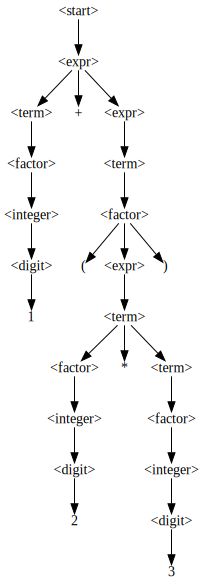

In [33]:
derivation_tree, *_ = EarleyParser(EXPR_GRAMMAR).parse(expr_input)
display_tree(derivation_tree)

### Simplifying by Replacing Subtrees

To simplify this tree, we could replace any `<expr>` symbol up in the tree with some `<expr>` subtree down in the tree.  For instance, we could replace the uppermost `<expr>` with its right `<expr>` subtree, yielding the string `(2 + 3)`:

In [34]:
import copy

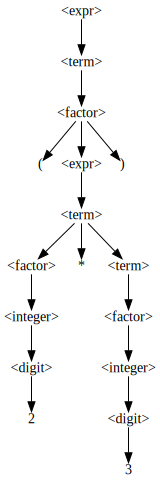

In [35]:
new_derivation_tree = copy.deepcopy(derivation_tree)
# We really should have some query language
sub_expr_tree = new_derivation_tree[1][0][1][2]
display_tree(sub_expr_tree)

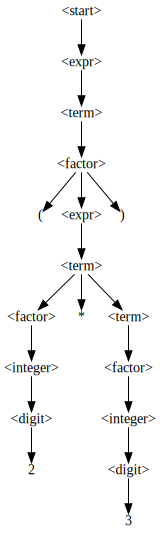

In [36]:
new_derivation_tree[1][0] = sub_expr_tree
display_tree(new_derivation_tree)

In [37]:
all_terminals(new_derivation_tree)

'(2 * 3)'

Replacing one subtree by another only works as long as individual elements such as `<expr>` occur multiple times in our tree.  In the reduced `new_derivation_tree`, above, we could replace further `<expr>` trees only once more.

### Simplifying by Alternative Expansions

A second means to simplify this tree is to apply _alternative expansions_.  That is, for a symbol, we check whether there is an alternative expansion with a smaller number of children.  Then, we replace the symbol with the alternative expansion, filling in needed symbols from the tree.

As an example, consider the `new_derivation_tree` above.  The applied expansion for `<term>` has been

    <term> ::= <term> * <factor>
    
Let us replace this with the alternative expansion:

    <term> ::= <factor>

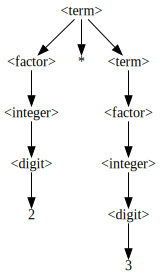

In [38]:
term_tree = new_derivation_tree[1][0][1][0][1][0][1][1][1][0]
display_tree(term_tree)

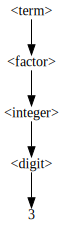

In [39]:
shorter_term_tree = term_tree[1][2]
display_tree(shorter_term_tree)

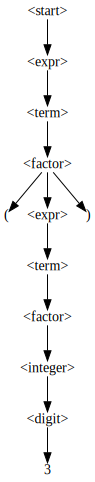

In [40]:
new_derivation_tree[1][0][1][0][1][0][1][1][1][0] = shorter_term_tree
display_tree(new_derivation_tree)

In [41]:
all_terminals(new_derivation_tree)

'(3)'

If we replace derivation subtrees by (smaller) subtrees, and if we search for alternate expansions that again yield smaller subtrees, we can systematically simplify the input.  This could be much faster than delta debugging, as our inputs would always be syntactically valid.  However, we need a strategy for when to apply which simplification rule. This is what we develop in the remainder of this section.

### Excursion: A Class for Reducing with Grammars

We introduce the `GrammarReducer` class, which is again a `Reducer`. Note that we derive from `CachingReducer`, as the strategy will produce several duplicates.

In [42]:
class GrammarReducer(CachingReducer):
    """Reduce inputs using grammars"""

    def __init__(self, runner: Runner, parser: Parser, *,
                 log_test: bool = False, log_reduce: bool = False):
        """Constructor.
        `runner` is the runner to be used.
        `parser` is the parser to be used.
        `log_test` - if set, show tests and results.
        `log_reduce` - if set, show reduction steps.
        """

        super().__init__(runner, log_test=log_test)
        self.parser = parser
        self.grammar = parser.grammar()
        self.start_symbol = parser.start_symbol()
        self.log_reduce = log_reduce
        self.try_all_combinations = False

#### A Few Helpers

We define a number of helper functions, which we will need for our strategy.  `tree_list_to_string()` does what the name suggest, creating a string from a list of derivation trees:

In [43]:
from GrammarFuzzer import DerivationTree

In [44]:
def tree_list_to_string(q: List[DerivationTree]) -> str:
    return "[" + ", ".join([all_terminals(tree) for tree in q]) + "]"

In [45]:
tree_list_to_string([derivation_tree, derivation_tree])

'[1 + (2 * 3), 1 + (2 * 3)]'

The function `possible_combinations()` takes a list of lists $[[x_1, x_2], [y_1, y_2], \dots]$ and creates a list of combinations $[[x_1, y_1], [x_1, y_2], [x_2, y_1], [x_2, y_2], \dots]$.

In [46]:
def possible_combinations(list_of_lists: List[List[Any]]) -> List[List[Any]]:
    if len(list_of_lists) == 0:
        return []

    ret = []
    for e in list_of_lists[0]:
        if len(list_of_lists) == 1:
            ret.append([e])
        else:
            for c in possible_combinations(list_of_lists[1:]):
                new_combo = [e] + c
                ret.append(new_combo)

    return ret

In [47]:
possible_combinations([[1, 2], ['a', 'b']])

[[1, 'a'], [1, 'b'], [2, 'a'], [2, 'b']]

The functions `number_of_nodes()` and `max_height()` return the number of nodes and the maximum height of the given tree, respectively.

In [48]:
def number_of_nodes(tree: DerivationTree) -> int:
    (symbol, children) = tree
    if children is None:
        return 1

    return 1 + sum([number_of_nodes(c) for c in children])

In [49]:
number_of_nodes(derivation_tree)

25

In [50]:
def max_height(tree: DerivationTree) -> int:
    (symbol, children) = tree
    if children is None or len(children) == 0:
        return 1

    return 1 + max([max_height(c) for c in children])

In [51]:
max_height(derivation_tree)

12

#### Simplification Strategies

Let us now implement our two simplification strategies – replacing subtrees and alternate expansions.

##### Finding Subtrees

The method `subtrees_with_symbol()` returns all subtrees in the given tree which's root is equal to the given symbol.  If `ignore_root` is set (default), then the root node of `tree` is not compared against.  (The `depth` parameter will be discussed below.)

In [52]:
class GrammarReducer(GrammarReducer):
    def subtrees_with_symbol(self, tree: DerivationTree,
                             symbol: str, depth: int = -1,
                             ignore_root: bool = True) -> List[DerivationTree]:
        """Find all subtrees in `tree` whose root is `symbol`.
        If `ignore_root` is true, ignore the root note of `tree`."""

        ret = []
        (child_symbol, children) = tree
        if depth <= 0 and not ignore_root and child_symbol == symbol:
            ret.append(tree)

        # Search across all children
        if depth != 0 and children is not None:
            for c in children:
                ret += self.subtrees_with_symbol(c,
                                                 symbol,
                                                 depth=depth - 1,
                                                 ignore_root=False)

        return ret

Here's an example: These are all subtrees with `<term>` in our derivation tree `derivation_tree`.

In [53]:
grammar_reducer = GrammarReducer(
    mystery,
    EarleyParser(EXPR_GRAMMAR),
    log_reduce=True)

In [54]:
all_terminals(derivation_tree)

'1 + (2 * 3)'

In [55]:
[all_terminals(t) for t in grammar_reducer.subtrees_with_symbol(
    derivation_tree, "<term>")]

['1', '(2 * 3)', '2 * 3', '3']

If we want to replace `<term>` subtrees to simplify the tree, these are the subtrees we could replace them with.

##### Alternate Expansions

Our second strategy, simplifying by alternate expansions, is a bit more complex.  We first fetch the possible expansions for the given symbol (starting with the ones with the fewest children).  For each expansion, we fill in values for the symbols from the subtree (using `subtrees_with_symbols()`, above).  We then pick the first possible combination (or _all_ combinations, if the attribute `try_all_combinations` is set).

In [56]:
class GrammarReducer(GrammarReducer):
    def alternate_reductions(self, tree: DerivationTree, symbol: str, 
                             depth: int = -1):
        reductions = []

        expansions = self.grammar.get(symbol, [])
        expansions.sort(
            key=lambda expansion: len(
                expansion_to_children(expansion)))

        for expansion in expansions:
            expansion_children = expansion_to_children(expansion)

            match = True
            new_children_reductions = []
            for (alt_symbol, _) in expansion_children:
                child_reductions = self.subtrees_with_symbol(
                    tree, alt_symbol, depth=depth)
                if len(child_reductions) == 0:
                    match = False   # Child not found; cannot apply rule
                    break

                new_children_reductions.append(child_reductions)

            if not match:
                continue  # Try next alternative

            # Use the first suitable combination
            for new_children in possible_combinations(new_children_reductions):
                new_tree = (symbol, new_children)
                if number_of_nodes(new_tree) < number_of_nodes(tree):
                    reductions.append(new_tree)
                    if not self.try_all_combinations:
                        break

        # Sort by number of nodes
        reductions.sort(key=number_of_nodes)

        return reductions

In [57]:
grammar_reducer = GrammarReducer(
    mystery,
    EarleyParser(EXPR_GRAMMAR),
    log_reduce=True)

In [58]:
all_terminals(derivation_tree)

'1 + (2 * 3)'

Here are _all_ combinations for `<term>`:

In [59]:
grammar_reducer.try_all_combinations = True
print([all_terminals(t)
       for t in grammar_reducer.alternate_reductions(derivation_tree, "<term>")])

['1', '2', '3', '1 * 1', '1 * 3', '2 * 1', '2 * 3', '3 * 1', '3 * 3', '(2 * 3)', '1 * 2 * 3', '2 * 2 * 3', '3 * 2 * 3', '1 * (2 * 3)', '(2 * 3) * 1', '(2 * 3) * 3', '2 * (2 * 3)', '3 * (2 * 3)']


The default, though, is simply to return the first of these:

In [60]:
grammar_reducer.try_all_combinations = False
[all_terminals(t) for t in grammar_reducer.alternate_reductions(
    derivation_tree, "<term>")]

['1', '1 * 1']

##### Both Strategies Together

Let us now merge both strategies.  To replace a subtree with a given symbol, we first search for already existing subtrees (using `subtrees_with_symbol()`); then we go for alternate expansions (using `alternate_expansions()`).

In [61]:
class GrammarReducer(GrammarReducer):
    def symbol_reductions(self, tree: DerivationTree, symbol: str, 
                          depth: int = -1):
        """Find all expansion alternatives for the given symbol"""
        reductions = (self.subtrees_with_symbol(tree, symbol, depth=depth)
                      + self.alternate_reductions(tree, symbol, depth=depth))

        # Filter duplicates
        unique_reductions = []
        for r in reductions:
            if r not in unique_reductions:
                unique_reductions.append(r)

        return unique_reductions

In [62]:
grammar_reducer = GrammarReducer(
    mystery,
    EarleyParser(EXPR_GRAMMAR),
    log_reduce=True)

In [63]:
all_terminals(derivation_tree)

'1 + (2 * 3)'

These are the possible reductions for `<expr>` nodes.  Note how we first return subtrees (`1 + (2 * 3)`, `(2 * 3)`, `2 * 3`) before going for alternate expansions of `<expr>` (`1`).

In [64]:
reductions = grammar_reducer.symbol_reductions(derivation_tree, "<expr>")
tree_list_to_string([r for r in reductions])

'[1 + (2 * 3), (2 * 3), 2 * 3, 1]'

These are the possible reductions for `<term>` nodes.  Again, we first have subtrees of the derivation tree, followed by the alternate expansion `1 * 1`.

In [65]:
reductions = grammar_reducer.symbol_reductions(derivation_tree, "<term>")
tree_list_to_string([r for r in reductions])

'[1, (2 * 3), 2 * 3, 3, 1 * 1]'

#### The Reduction Strategy

We are now able to return a number of alternatives for each symbol in the tree.  This is what we apply in the core function of our reduction strategy, `reduce_subtree()`.  Starting with `subtree`, for every child, we find possible reductions.  For every reduction, we replace the child with the reduction and test the resulting (full) tree.  If it fails, our reduction was successful; otherwise, we put the child back into place and try out the next reduction.  Eventually, we apply `reduce_subtree()` on all children, reducing these as well.

In [66]:
class GrammarReducer(GrammarReducer):
    def reduce_subtree(self, tree: DerivationTree,
                       subtree: DerivationTree, depth: int = -1):
        symbol, children = subtree
        if children is None or len(children) == 0:
            return False

        if self.log_reduce:
            print("Reducing", all_terminals(subtree), "with depth", depth)

        reduced = False
        while True:
            reduced_child = False
            for i, child in enumerate(children):
                if child is None:
                    continue

                (child_symbol, _) = child
                for reduction in self.symbol_reductions(
                        child, child_symbol, depth):
                    if number_of_nodes(reduction) >= number_of_nodes(child):
                        continue

                    # Try this reduction
                    if self.log_reduce:
                        print(
                            "Replacing",
                            all_terminals(
                                children[i]),
                            "by",
                            all_terminals(reduction))
                    children[i] = reduction
                    if self.test(all_terminals(tree)) == Runner.FAIL:
                        # Success
                        if self.log_reduce:
                            print("New tree:", all_terminals(tree))
                        reduced = reduced_child = True
                        break
                    else:
                        # Didn't work out - restore
                        children[i] = child

            if not reduced_child:
                if self.log_reduce:
                    print("Tried all alternatives for", all_terminals(subtree))
                break

        # Run recursively
        for c in children:
            if self.reduce_subtree(tree, c, depth):
                reduced = True

        return reduced

All we now need is a few drivers.  The method `reduce_tree()` is the main entry point into `reduce_subtree()`:

In [67]:
class GrammarReducer(GrammarReducer):
    def reduce_tree(self, tree):
        return self.reduce_subtree(tree, tree)

The custom method `parse()` turns a given input into a derivation tree:

In [68]:
class GrammarReducer(GrammarReducer):
    def parse(self, inp):
        tree, *_ = self.parser.parse(inp)
        if self.log_reduce:
            print(all_terminals(tree))
        return tree

The method `reduce()` is the one single entry point, parsing the input and then reducing it.

In [69]:
class GrammarReducer(GrammarReducer):
    def reduce(self, inp):
        tree = self.parse(inp)
        self.reduce_tree(tree)
        return all_terminals(tree)

### End of Excursion

Let us try out our `GrammarReducer` class in practice on our input `expr_input` and the `mystery()` function.  How quickly can we reduce it?

In [70]:
expr_input

'1 + (2 * 3)'

In [71]:
grammar_reducer = GrammarReducer(
    eval_mystery,
    EarleyParser(EXPR_GRAMMAR),
    log_test=True)
grammar_reducer.reduce(expr_input)

Test #1 '(2 * 3)' 7 FAIL
Test #2 '2 * 3' 5 PASS
Test #3 '3' 1 PASS
Test #4 '2' 1 PASS
Test #5 '(3)' 3 FAIL


'(3)'

Success!  In only five steps, our `GrammarReducer` reduces the input to the minimum that causes the failure.  Note how all tests are syntactically valid by construction, avoiding the `UNRESOLVED` outcomes that cause delta debugging to stall.

### A Depth-Oriented Strategy

Even if five steps are already good, we can still do better.  If we look at the log above, we see that after test `#2`, where the input (tree) is reduced to `2 * 3`, our `GrammarReducer` first tries to replace the tree with `2` and `3`, which are the alternate `<term>` subtrees.  This may work, of course; but if there are many possible subtrees, our strategy will spend quite some time trying one after the other.

Delta debugging, as introduced above, follows the idea of trying to cut inputs approximately in half, and thus quickly proceeds towards a minimal input.  By replacing a tree with much smaller subtrees, we _could_ possibly reduce a tree significantly, but may need several attempts to do so.  A better strategy is to only consider _large_ subtrees first – both for the subtree replacement as well as for alternate expansions.  To find such _large_ subtrees, we limit the _depth_ by which we search for possible replacements in the subtree – first, by looking at the direct descendants, later at lower descendants.

This is the role of the `depth` parameter used in `subtrees_with_symbol()` and passed through the invoking functions.  If set, _only_ symbols at the given depth are returned.  Here's an example, starting again with our derivation tree `derivation_tree`:

In [72]:
grammar_reducer = GrammarReducer(
    mystery,
    EarleyParser(EXPR_GRAMMAR),
    log_reduce=True)

In [73]:
all_terminals(derivation_tree)

'1 + (2 * 3)'

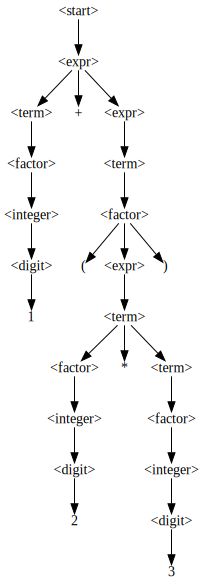

In [74]:
display_tree(derivation_tree)

At a depth of 1, there is no `<term>` symbol:

In [75]:
[all_terminals(t) for t in grammar_reducer.subtrees_with_symbol(
    derivation_tree, "<term>", depth=1)]

[]

At a depth of 2, we have the `<term>` subtree on the left hand side:

In [76]:
[all_terminals(t) for t in grammar_reducer.subtrees_with_symbol(
    derivation_tree, "<term>", depth=2)]

['1']

At a depth of 3, we have the `<term>` subtree on the right hand side:

In [77]:
[all_terminals(t) for t in grammar_reducer.subtrees_with_symbol(
    derivation_tree, "<term>", depth=3)]

['(2 * 3)']

The idea is now to start with a depth of 0, subsequently increasing it as we proceed:

In [78]:
class GrammarReducer(GrammarReducer):
    def reduce_tree(self, tree):
        depth = 0
        while depth < max_height(tree):
            reduced = self.reduce_subtree(tree, tree, depth)
            if reduced:
                depth = 0    # Start with new tree
            else:
                depth += 1   # Extend search for subtrees
        return tree        

In [79]:
grammar_reducer = GrammarReducer(
    mystery,
    EarleyParser(EXPR_GRAMMAR),
    log_test=True)
grammar_reducer.reduce(expr_input)

Test #1 '(2 * 3)' 7 FAIL
Test #2 '(3)' 3 FAIL
Test #3 '3' 1 PASS


'(3)'

We see that a depth-oriented strategy needs even fewer steps in our setting.

### Comparing Strategies

We close by demonstrating the difference between text-based delta debugging and our grammar-based reduction.  We build a very long expression:

In [80]:
from GrammarFuzzer import GrammarFuzzer

In [81]:
long_expr_input = GrammarFuzzer(EXPR_GRAMMAR, min_nonterminals=100).fuzz()
long_expr_input

'++---((-2 / 3 / 3 - -+1 / 5 - 2) * ++6 / +8 * 4 / 9 / 2 * 8 + ++(5) * 3 / 8 * 0 + 3 * 3 + 4 / 0 / 6 + 9) * ++++(+--9 * -3 * 7 / 4 + --(4) / 3 - 0 / 3 + 5 + 0) * (1 * 6 - 1 / 9 * 5 - 9 / 0 + 7) * ++(8 - 1) * +1 * 7 * 0 + ((1 + 4) / 4 * 8 * 9 * 4 + 4 / (4) * 1 - (4) * 8 * 5 + 1 + 4) / (+(2 - 1 - 9) * 5 + 3 + 6 - 2) * +3 * (3 - 7 + 8) / 4 - -(9 * 4 - 1 * 0 + 5) / (5 / 9 * 5 + 2) * 7 + ((7 - 5 + 3) / 1 * 8 - 8 - 9) * --+1 * 4 / 4 - 4 / 7 * 4 - 3 / 6 * 1 - 2 - 7 - 8'

With grammars, we need only a handful of tests to find the failure-inducing input:

In [82]:
from Timer import Timer

In [83]:
grammar_reducer = GrammarReducer(eval_mystery, EarleyParser(EXPR_GRAMMAR))
with Timer() as grammar_time:
    print(grammar_reducer.reduce(long_expr_input))

(9)


In [84]:
grammar_reducer.tests

10

In [85]:
grammar_time.elapsed_time()

0.15811178299999895

Delta debugging, in contrast, requires orders of magnitude more tests (and consequently, time).  Again, the reduction is not closely as perfect as it is with the grammar-based reducer.

In [86]:
dd_reducer = DeltaDebuggingReducer(eval_mystery)
with Timer() as dd_time:
    print(dd_reducer.reduce(long_expr_input))

((2 - 1 - 2) * 8 + (5) - (4)) / ((2) * 3) * (9) / 3 / 1 - 8


In [87]:
dd_reducer.tests

900

In [88]:
dd_time.elapsed_time()

5.4580275490000005

We see that if an input is syntactically complex, using a grammar to reduce inputs is the best way to go.

## Synopsis

A _reducer_ takes a failure-inducing input and reduces it to the minimum that still reproduces the failure.  This chapter provides `Reducer` classes that implement such reducers.

Here is a simple example: An arithmetic expression causes an error in the Python interpreter:

In [89]:
!python -c 'x = 1 + 2 * 3 / 0'

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ZeroDivisionError: division by zero


Can we reduce this input to a minimum?  To use a `Reducer`, one first has to build a `Runner` whose outcome is `FAIL` if the precise error occurs.  We therefore build a `ZeroDivisionRunner` whose `run()` method will specifically return a `FAIL` outcome if a `ZeroDivisionError` occurs.

In [90]:
from Fuzzer import ProgramRunner
import subprocess

In [91]:
class ZeroDivisionRunner(ProgramRunner):
    """Make outcome 'FAIL' if ZeroDivisionError occurs"""

    def run(self, inp: str = "") -> Tuple[subprocess.CompletedProcess, Outcome]:
        process, outcome = super().run(inp)
        if process.stderr.find('ZeroDivisionError') >= 0:
            outcome = 'FAIL'
        return process, outcome

If we feed this expression into a `ZeroDivisionRunner`, it will produce an outcome of `FAIL` as designed.

In [92]:
python_input = "x = 1 + 2 * 3 / 0"
python_runner = ZeroDivisionRunner("python")
process, outcome = python_runner.run(python_input)
outcome

'FAIL'

Delta Debugging is a simple and robust reduction algorithm.  We can tie a `DeltaDebuggingReducer` to this runner, and have it determine the substring that causes the `python` program to fail:

In [93]:
dd = DeltaDebuggingReducer(python_runner)
dd.reduce(python_input)

'3/0'

The input is reduced to the minimum: We get the essence of the division by zero.

In [94]:
# ignore
from ClassDiagram import display_class_hierarchy

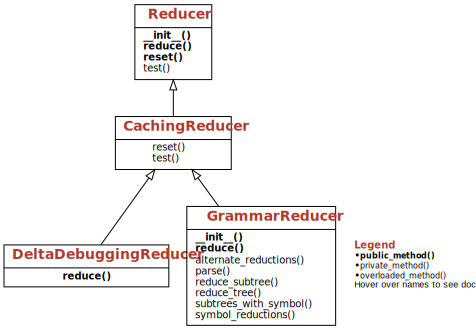

In [95]:
# ignore
display_class_hierarchy([DeltaDebuggingReducer, GrammarReducer],
                        public_methods=[
                            Reducer.__init__,
                            Reducer.reset,
                            Reducer.reduce,
                            DeltaDebuggingReducer.reduce,
                            GrammarReducer.__init__,
                            GrammarReducer.reduce,
                        ],
                        types={
                            'DerivationTree': DerivationTree,
                            'Grammar': Grammar,
                            'Outcome': Outcome,
                        },
                        project='fuzzingbook')

## Lessons Learned

* Reducing failure-inducing inputs to a minimum is helpful for testing and debugging.
* _Delta debugging_ is a simple and robust algorithm to easily reduce test cases.
* For syntactically complex inputs, _grammar-based reduction_ is much faster and yields better results.

## Next Steps

Our next chapter focuses on [Web GUI Fuzzing](WebFuzzer.ipynb), another domain where generating and reducing test cases is central.

## Background

The "lexical" delta debugging algorithm discussed here stems from \cite{Zeller2002}; actually, this is the exact Python implementation as used by Zeller in 2002.  The idea of systematically reducing inputs has been discovered a number of times, although not as  automatic and generic as delta debugging. \cite{Slutz1998}, for instance, discusses systematic reduction of SQL statements for SQL databases; the general process as manual work is well described by \cite{Kernighan1999}.

The deficits of delta debugging as it comes to syntactically complex inputs were first discussed in *compiler testing*, and _reducing tree inputs_ rather than string inputs was quickly discovered as an alternative.  *Hierarchical Delta Debugging* (*HDD*) \cite{Misherghi2006} applies delta debugging on subtrees of a parse tree, systematically reducing a parse tree to a minimum.  _Generalized Tree Reduction_ \cite{Herfert2017} generalizes this idea to apply arbitrary _patterns_ such as replacing a term by a compatible term in a subtree, as `subtrees_with_symbol()` does.  Using _grammars_ to reduce inputs was first implemented in the _Perses_ tool \cite{Sun2018}; our algorithm implements very similar strategies.  Searching for alternate expansions (as `alternate_reductions()`) is a contribution of the present chapter.

While `GrammarReducer` is a generic approach that can be parameterized with an arbitrary grammar, _language-specific_ approaches can do a much better job for the language at hand.  *C-Reduce* \cite{Regehr2012} is a reducer specifically targeting the reduction of programming languages.  Besides reductions in the style of delta debugging or tree transformations, C-Reduce comes with more than 30 source-to-source transformations that replace aggregates by scalars, remove function parameters at a definition and all call sites, change functions to return `void` and deleting all `return` statements, and many more.  While specifically instantiated for the C language (and used for testing C compilers), these principles extend to arbitrary programming languages following an ALGOL-like syntax.  When testing a compiler, C-Reduce is the tool to go for.

The chapter on ["Reducing Failure-Inducing Inputs" in the Debugging Book](https://www.debuggingbook.org/html/DeltaDebugger.html) has an alternate implementation `DeltaDebugger` of delta debugging that is even easier to deploy; here, one simply writes

```python
with DeltaDebugger() as dd:
    fun(args...)
dd
```

to reduce the input in `args` for a failing (exception-throwing) function `fun()`. The chapter also  discusses further usage examples, including reducing _code_ to a minimum.

This [blog post](https://www.drmaciver.com/2019/01/notes-on-test-case-reduction/) by David McIver contains lots of insights on how to apply reduction in practice, in particular multiple runs with different abstraction levels.

## Exercises

How to best reduce inputs is still an underdeveloped field of research, with lots of opportunities.

### Exercise 1: Mutation-Based Fuzzing with Reduction

When fuzzing with a population, it can be useful to occasionally _reduce_ the length of each element, such that future descendants are shorter, too, which typically speeds up their testing.

Consider the `MutationFuzzer` class from [the chapter on mutation-based fuzzing](MutationFuzzer.ipynb). 
Extend it such that whenever a new input is added to the population, it is first reduced using delta debugging.

**Solution.** Left to the reader.

### Exercise 2: Reduction by Production

Grammar-based input reduction, as sketched above, might be a good algorithm, but is by no means the only alternative.  One interesting question is whether "reduction" should only be limited to elements already present, or whether one would be allowed to also create _new_ elements.  These would not be present in the original input, yet still allow to produce a much smaller input that would still reproduce the original failure.

As an example, consider the following grammar:

```
<number> ::= <float> | <integer> | <not-a-number>
<float> ::= <digits>.<digits>
<integer> ::= <digits>
<not-a-number> ::= NaN
<digits> ::= [0-9]+
```

Assume the input `100.99` fails.  We might be able to reduce it to a minimum of, say, `1.9`.  However, we cannot reduce it to an `<integer>` or to `<not-a-number>`, as these symbols do not occur in the original input.  By allowing to _create_ alternatives for these symbols, we could also tests inputs such as `1` or `NaN` and further generalize the class of inputs for which the program fails.

Create a class `GenerativeGrammarReducer` as subclass of `GrammarReducer`; extend the method `reduce_subtree()` accordingly.

**Solution.** Left to the reader.

### Exercise 3: The Big Reduction Shoot-Out

Create a _benchmark_ for the grammars already defined earlier, consisting of:

1. A set of _inputs_, produced from these very grammars using `GrammarFuzzer` and derivatives;
2. A set of _tests_ which check for the occurrence of individual symbols as well as pairs and triples of these symbols:
    * Tests should be _unresolved_ if the input is not syntactically valid;
    * Tests should _fail_ if the symbols (or pairs or triples thereof) occur;
    * Tests should _pass_ in all other cases.
    
Compare delta debugging and grammar-based debugging on the benchmark.  Implement HDD \cite{Misherghi2006} and _Generalized Tree Reduction_ \cite{Herfert2017} and add them to your comparison.  Which approach performs best, and under which circumstances?

**Solution.** Left to the reader.